In [6]:
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
Nashville = ox.graph.graph_from_point((36.164431,-86.772042),dist = 7000,network_type= "drive", dist_type = "network",retain_all = True)

In [ ]:
nodes = ox.graph_to_gdfs(Nashville, edges=False)
nodes = nodes.dropna(axis = 0, subset = ['highway']).reset_index()
nodes.head()

In [ ]:
G_nash = ox.utils_graph.get_largest_component(Nashville, strongly=True) # to make sure OD pair is reachable
G_nash_dm = nx.to_undirected(G_nash)  # convert to undirect graph

In [2]:
def network_distance_matrix(u, G, vs):
    
    dists = []
    for v in vs:
        
        try: 
            dists.append(nx.dijkstra_path_length(G, source=u, target=v, weight='length'))
        except:
            dists.append(np.nan)
#     dists = [ for v in vs]
        
    return pd.Series(dists, index=vs)

- select OD pairs

In [307]:
# randomly choose 40 points
np.random.seed(seed = 650)
# node_idx = np.random.randint(low = 1, high = len(nodes), size = 20 )  # 20 
node_idx = random.sample(np.arange(1,len(nodes),1).tolist(), 40)
# node_idx
selected_node = nodes.iloc[node_idx].reset_index(drop = True)
node_dm = selected_node['osmid'].apply(network_distance_matrix, G=G_nash, vs= selected_node.osmid)

In [205]:
node_dm.index = node_dm.columns
Destination = node_dm.idxmax(axis = 1)  # choose the maximum shortest path as D 
Origin = node_dm.index.tolist()
SP = node_dm.max(axis = 0)  # unit: meters

- compute the Great Circle Distance, which is more pratical than euclidean distance between two points

In [180]:
# great circle distance, similar to L2 distance
Great_circle = []
Ori = []
Dest = []
for ori, dest in zip(Destination, Origin):
    
    ori_lat = nodes[nodes.osmid== ori]['y'].values[0]
    ori_long = nodes[nodes.osmid== ori]['x'].values[0]
    dest_lat = nodes[nodes.osmid== dest]['y'].values[0]
    dest_long = nodes[nodes.osmid== dest]['x'].values[0]
    
    Ori.append((ori_long, ori_lat))
    Dest.append((dest_long, dest_lat))
    
    Great_circle.append(ox.distance.great_circle_vec(ori_lat, ori_long, 
                                                     dest_lat, dest_long,
                                                     earth_radius=6371009)) 

- the unit of shortest path and great circle distance is mile.

In [184]:
Dist_matrix = pd.DataFrame(SP, columns = ['shortest_path'])
Dist_matrix['shortest_path']= Dist_matrix['shortest_path']/1609.34
Dist_matrix['Ori'] = Ori
Dist_matrix['Dest'] = Dest
Dist_matrix['Great_circle_dist'] = np.array(Great_circle) /1609.34
Dist_matrix['Origin_label'] = Origin
Dist_matrix['Destination_label'] = Destination
Dist_matrix['ratio'] = Dist_matrix['shortest_path']/Dist_matrix['Great_circle_dist']
Dist_matrix.head()

,shortest_path,Ori,Dest,Great_circle_dist,Origin_label,Destination_label,ratio
osmid,,,,,,,
202185485,5.135789,"(-86.7331183, 36.1970452)","(-86.7881423, 36.1542072)",4.263626,202185485,202506512,1.204559
3416360817,4.666239,"(-86.7670098, 36.1123928)","(-86.7840814, 36.1716199)",4.201613,3416360817,202294428,1.110583
202338733,4.318490,"(-86.7670098, 36.1123928)","(-86.7819735, 36.1683127)",3.952894,202338733,202294428,1.092488
202249903,5.447856,"(-86.7331183, 36.1970452)","(-86.7952914, 36.1521037)",4.654737,202249903,202506512,1.170390
202257186,4.855725,"(-86.7670098, 36.1123928)","(-86.7846953, 36.1750425)",4.439742,202257186,202294428,1.093695


- display some routes

In [170]:
Route = []
for r_o, r_d in zip(Destination[0:5], Origin[0:5]):  
    Route.append(nx.shortest_path(G_dm,r_o ,r_d , weight="length", method = 'dijkstra'))

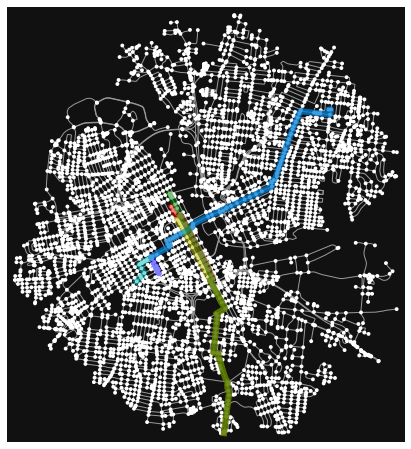

In [172]:
fig,ax  = ox.plot_graph_routes(G_dm, routes = Route, route_colors=['b','r','y','c','g'], orig_dest_size = 0.4, route_linewidth=6)                                                                     

(1.0, 2.0)

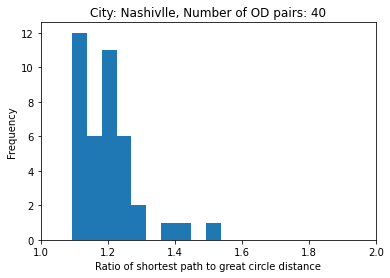

In [204]:
fig, ax = plt.subplots()
ax.hist(Dist_matrix['ratio'],bins = 10)
ax.set_xlabel('Ratio of shortest path to great circle distance')
ax.set_ylabel('Frequency')
ax.set_title("City: Nashivlle, Number of OD pairs: 40")
# sns.histplot(data=Dist_matrix, x="ratio", binwidth=0.1, ax = ax)
ax.set_xlim([1,2])

### encapsulate above code

- write function for iteration

In [15]:
def get_ratio(city_centriod, city):
    
#     for exmaple: Nashville
#     city_centriod = (36.164431,-86.772042)
    city = ox.graph.graph_from_point(city_centriod, dist = 7000,network_type= "drive", dist_type = "network",retain_all = True) 
    
    nodes = ox.graph_to_gdfs(city, edges=False)
    nodes = nodes.dropna(axis = 0, subset = ['highway']).reset_index()
#     nodes.head()
    G_city = ox.utils_graph.get_largest_component(city, strongly=True) # to make sure OD pair is reachable
#     G_city_dm = nx.to_undirected(G_city)  # convert to undirect graph
    G_city_dm = ox.utils_graph.get_undirected(G_city)
    
    # randomly choose 40 points
    random.seed(652)
    # node_idx = np.random.randint(low = 1, high = len(nodes), size = 20 )  # 20 
    node_idx = random.sample(np.arange(1,len(nodes),1).tolist(), 40)
    # node_idx
    selected_node = nodes.iloc[node_idx].reset_index(drop = True)
    node_dm = selected_node['osmid'].apply(network_distance_matrix, G=G_city, vs= selected_node.osmid)
    
    node_dm.index = node_dm.columns
#     print(node_dm)
    Destination = node_dm.idxmax(axis = 1, skipna = True)  # choose the maximum shortest path as D 
#     print(Destination)
    Origin = node_dm.index.tolist()
    SP = node_dm.max(axis = 1, skipna = True)  # unit: meters
    
    # great circle distance, similar to L2 distance
    Great_circle = []
    Ori = []
    Dest = []
    
    for ori, dest in zip(Destination, Origin):
        
        
        ori_lat = selected_node[selected_node.osmid== ori]['y'].values[0]
        ori_long = selected_node[selected_node.osmid== ori]['x'].values[0]
        dest_lat = selected_node[selected_node.osmid== dest]['y'].values[0]
        dest_long = selected_node[selected_node.osmid== dest]['x'].values[0]

        Ori.append((ori_lat, ori_long))
        Dest.append((dest_lat, dest_long))

        Great_circle.append(ox.distance.great_circle_vec(ori_lat, ori_long, 
                                                         dest_lat, dest_long,
                                                         earth_radius=6371009)) 
        
        
    Dist_matrix = pd.DataFrame(SP, columns = ['shortest_path'])
    Dist_matrix['shortest_path']= Dist_matrix['shortest_path']/1609.34
    Dist_matrix['Ori'] = Ori
    Dist_matrix['Dest'] = Dest
    Dist_matrix['Great_circle_dist'] = np.array(Great_circle) /1609.34
    Dist_matrix['Origin_label'] = Origin
    Dist_matrix['Destination_label'] = Destination
    Dist_matrix['ratio'] = Dist_matrix['shortest_path']/Dist_matrix['Great_circle_dist']
    Avg_ratio = Dist_matrix.ratio.mean()
    
    # display some routes
    Route = []
    for r_o, r_d in zip(Destination[5:8], Origin[5:8]):  
        Route.append(nx.shortest_path(G_city, r_o ,r_d , weight="length", method = 'dijkstra'))
    fig1, ax1  = ox.plot_graph_routes(G_city, routes = Route, route_colors=['b','r','y'], orig_dest_size = 0.4, route_linewidth=6)   
    
    
    city = city
    fig2, ax2 = plt.subplots()
    ax2.hist(Dist_matrix['ratio'],bins = 10)
    ax2.set_xlabel('Ratio of shortest path to great circle distance')
    ax2.set_ylabel('Frequency')
    ax2.set_title("City: {}, Number of OD pairs: 40".format(city))
    # sns.histplot(data=Dist_matrix, x="ratio", binwidth=0.1, ax = ax)
    ax2.set_xlim([1,2])

    
    return fig1, fig2, Dist_matrix, Avg_ratio

In [16]:
nash_centroid = (36.164431,-86.772042)
knox_centroid = (35.961871,-83.929471)
NewYork_centroid = (40.75308327430581, -73.98689783873529)
LosAngeles_centroid = (34.05490749362612, -118.3083980015528)

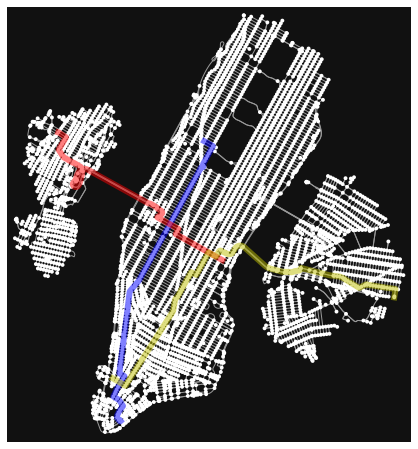

1.4163902359756564

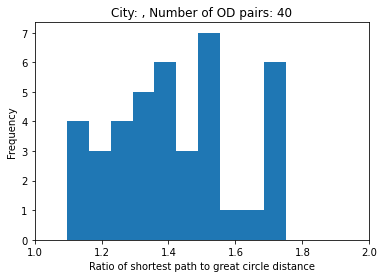

In [17]:
city = "New York"
fig1, fig2, Dist_matrix, Avg_ratio = get_ratio(city_centriod = NewYork_centroid,city = city)
Dist_matrix.to_excel('{}.xlsx'.format(city))
Avg_ratio

In [339]:
Avg_ratio

1.2127740803863056

In [13]:
Dist_matrix['ratio'].max()

1.5040791216858456